# Анализ воронки продаж

В рамках проекта, необходимо изучить воронку продаж. Проанализировать, как и какое количество пользователей доходят до покупки продуктов питания, есть ли стоп-факторы на пути воронки.

**План проверки:** 

* Подготовим данные к анализу
* Изучим данные выборки
* Изучим и выберем актуальный период для проверки
* Проанализируем движение пользователей в приложении
* Проведем эксперимент с контрольной группой и экспериментальной 


## Изучим данные

In [1]:
#импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import scipy.stats as st

In [2]:
#загрузка данных
try:
    logs = pd.read_csv('/Users/macbookair/Desktop/logs_exp.csv')
except:
      logs = pd.read_csv('/datasets/logs_exp.csv', sep ='\t')

In [3]:
logs.head(5)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Описание данных

Каждая запись в логе — это действие пользователя, или событие. 

`EventName` — название события;

`DeviceIDHash` — уникальный идентификатор пользователя;

`EventTimestamp` — время события;

`ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

## Подготовим данные

In [4]:
# заменим столбцы
logs = logs.rename(columns={'EventName' : 'event_name', 'DeviceIDHash' : 'device_id', 'EventTimestamp' : 'event_time', 'ExpId' : 'exp_id'})
print(logs.columns)

Index(['event_name', 'device_id', 'event_time', 'exp_id'], dtype='object')


In [5]:
# проверим пропуски, дубликаты и тип данных
display(logs.info())
print(f'Количество дубликатов {logs.duplicated().sum()}')
print(f'Количество пропусков {logs.isnull().sum().sum()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   event_name  244126 non-null  object
 1   device_id   244126 non-null  int64 
 2   event_time  244126 non-null  int64 
 3   exp_id      244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


None

Количество дубликатов 413
Количество пропусков 0


In [6]:
# преобразование времени
logs.event_time = pd.to_datetime(logs.event_time, unit='s')

# создание столбца с датой
logs['event_date'] = logs.event_time.dt.date

# удаление дубликатов 
logs = logs.drop_duplicates().reset_index(drop=True)

## Изучите и проверьте данные

### Изучим данные

In [7]:
print(f'Сколько всего событий в логе - {len(logs)}')
print(f'Сколько всего пользователей в логе - {len(logs.device_id.unique())}.')
print(f'Сколько в среднем событий приходится на пользователя - {int(len(logs) / len(logs.device_id.unique()))}')

Сколько всего событий в логе - 243713
Сколько всего пользователей в логе - 7551.
Сколько в среднем событий приходится на пользователя - 32


### Изучим период событий

За какой период времени выбраны события?

In [8]:
print(f'Минимальная дата - {logs.event_time.min()}')
print(f'Максимальная дата - {logs.event_time.max()}')

Минимальная дата - 2019-07-25 04:43:36
Максимальная дата - 2019-08-07 21:15:17


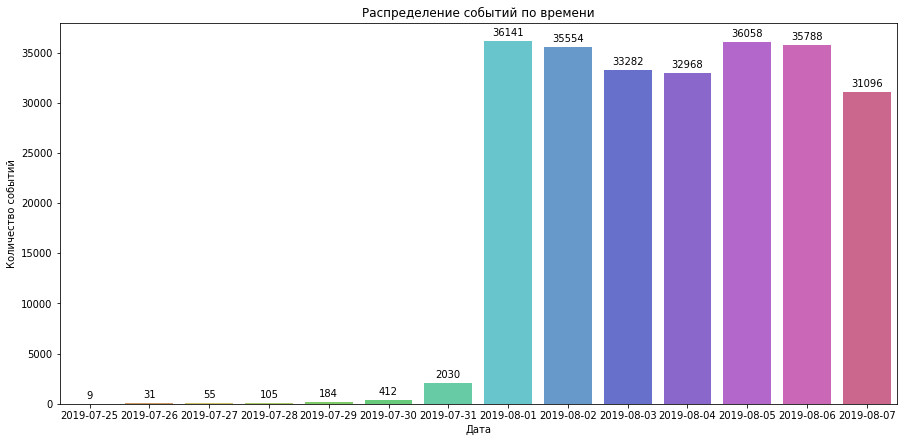

In [9]:
time_period = logs.groupby('event_date')[['event_name']].count().reset_index()

plt.figure(figsize=(15, 7))
ax = sns.barplot(x='event_date', y='event_name', data=time_period, palette='hls')
for i, v in time_period.iterrows():
       ax.text(i, v[1]+500, str(v[1]), ha='center')
plt.title('Распределение событий по времени')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.show()

**Период выборки - с 25 июля по 7 августа 2019 года (2 недели)**

С 1 августа видим резкий рост событий с 2 тыс. до 36 тыс. Предполгается, что на вторую неделю была запущена рекламная кампания, которая повлияла на скачок. Данные за первую неделю будут для нас не актуальными.

### Фильтруем данные

Отфильтруем данные, уберем 1 неделю и посмотрим, как это повлияет на нашу выборку

In [10]:
# убираем 1 неделю 
logs_2w = logs.query('event_date >= datetime(2019, 8, 1).date()')
print(logs_2w.info())
print()
print(f'{(len(logs_2w) / len(logs)):.2%} - количество событий второй недели')
print(f'Всего пользователей во второй неделе {len(logs_2w.device_id.unique())}.')
print()
print(logs_2w.groupby('exp_id')['device_id'].nunique())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240887 entries, 2826 to 243712
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  240887 non-null  object        
 1   device_id   240887 non-null  int64         
 2   event_time  240887 non-null  datetime64[ns]
 3   exp_id      240887 non-null  int64         
 4   event_date  240887 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 11.0+ MB
None

98.84% - количество событий второй недели
Всего пользователей во второй неделе 7534.

exp_id
246    2484
247    2513
248    2537
Name: device_id, dtype: int64


* ~99% данных содержит вторая неделя, это 7534 пользователя из 7551
* После фильтрации мы потеряли 1,16% данных
* В выборке остались пользователи всех трех групп 246,247 и 248
* Группы примерно равны по количеству

## Изучим воронку событий

###  Посмотрим на данные воронки

Какие события есть в логах, как часто они встречаются

In [11]:
logs_2w.event_name.unique()

array(['Tutorial', 'MainScreenAppear', 'OffersScreenAppear',
       'CartScreenAppear', 'PaymentScreenSuccessful'], dtype=object)

**Выборка содержит 5 событий**

**Образуют путь пользователя по приложению, от открытия главной страницы до покупки продуктов питания:**

`MainScreenAppear` - просмотр главной страницы

`OffersScreenAppear` - просмотр страницы предложений

`CartScreenAppear` - просмотр корзины

`PaymentScreenSuccessful` - переход на страницу успешной оплаты

**Помогает пользователям соориентироваться на сайте:**

`Tutorial` - просмотр обучающей информации для новых пользователей

### Cколько пользователей совершали каждое из этих событий 
<a id='events'></a>

In [12]:
# сгруппируем таблицу по событиям
event_users = logs_2w.groupby('event_name').agg({'device_id':'nunique'}).reset_index()
event_users.set_axis(['event_name', 'users_count'], axis='columns', inplace=True)

# какой процент уникальных пользователей совершала это событие
event_users['%'] = event_users.users_count / logs_2w['device_id'].nunique()
event_users = event_users.sort_values('users_count', ascending=False).reset_index(drop=True)

# построим воронку
event_users['funnel'] = 1
for i in range(1, 4):
    event_users.loc[i, 'funnel'] = event_users.loc[i, 'users_count'] /  (event_users.loc[i-1, 'users_count'])

event_users

,event_name,users_count,%,funnel
0,MainScreenAppear,7419,0.984736,1.000000
1,OffersScreenAppear,4593,0.609636,0.619086
2,CartScreenAppear,3734,0.495620,0.812976
3,PaymentScreenSuccessful,3539,0.469737,0.947777
4,Tutorial,840,0.111495,1.000000


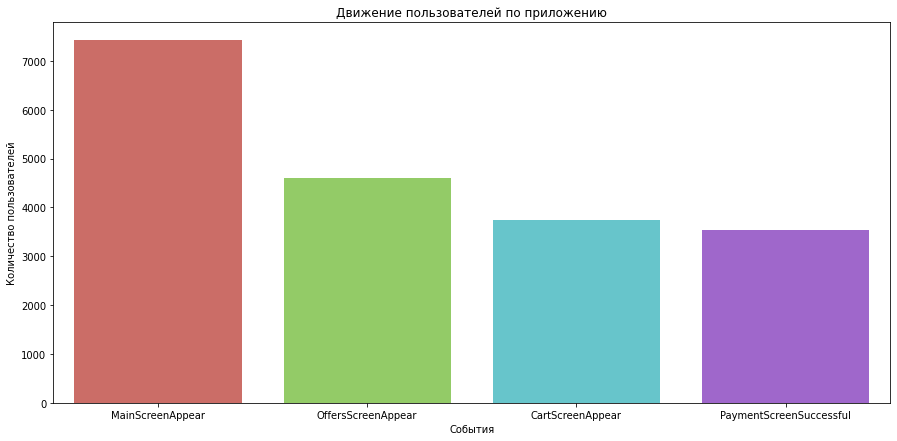

In [13]:
plt.figure(figsize=(15, 7))
sns.barplot(data=event_users.loc[0:3], x='event_name', y='users_count', palette='hls')
plt.title('Движение пользователей по приложению')
plt.xlabel('События')
plt.ylabel('Количество пользователей')
plt.show()

 <div style="border: solid bisque 2px; padding: 20px; font-size: 16px;">
    
* 98% пользователей не заходит на главную страницу, значит пользователи могут попасть сразу на другие страницы приложения
    
* 60% посещают каталог
    
* Около 40% пользователей не переходят в каталог

* 19% не переходят в корзину
    
* 5% не переходят на страницу оплаты
    
**Всего 47% пользователей совершают оплату**
    
    
</div>

## Изучим результаты эксперимента
<a id='test'></a>

###  Проведем А/А-тест

In [14]:
logs_2w.groupby('exp_id')['device_id'].nunique()

exp_id
246    2484
247    2513
248    2537
Name: device_id, dtype: int64

Группы 246 и 247 - контрольные (2484 и 2513 пользователей)

Группа - 248 экспериментальная (2537 пользователей)

**Условия успешного A/A теста:**

* Разница в количества в группах должна быть не более 1%

* Данные о движении пользователей не должны иметь различий 

* Данные не имеют статистической значимости 

* Ключевые метрики не имеют различия больше 1%

* Пользователь группы проходит до конца теста

In [15]:
# разница в количестве пользователей между группами
for i in range(0, 3):
    group = [246, 247, 248, 246]
    print(f'Разница между группой {group[i]} и {group[i+1]} составляет {1 - logs_2w.query("exp_id == @group[@i]")["device_id"].nunique() / logs_2w.query("exp_id == @group[@i+1]")["device_id"].nunique():.2%}')

Разница между группой 246 и 247 составляет 1.15%
Разница между группой 247 и 248 составляет 0.95%
Разница между группой 248 и 246 составляет -2.13%


Разница между группами незначительная

In [16]:
len(logs_2w.groupby('device_id')['exp_id'].nunique().reset_index().query('exp_id > 1'))

0

Нет пользователей, попавших в несколько групп

Посмотрим,какое количество пользователей совершило каждое событие от общего количества пользователей в группах

In [17]:
# распределим пользователей по группам и событиям
events_groups = logs_2w.pivot_table(index='event_name', columns='exp_id', values='device_id', aggfunc='nunique', margins=True).reset_index().sort_values('All', ascending=False).reset_index(drop=True)
events_groups = events_groups.reindex([1, 2, 3, 4, 5, 0]).reset_index(drop=True)
events_groups

exp_id,event_name,246,247,248,All
0,MainScreenAppear,2450,2476,2493,7419
1,OffersScreenAppear,1542,1520,1531,4593
2,CartScreenAppear,1266,1238,1230,3734
3,PaymentScreenSuccessful,1200,1158,1181,3539
4,Tutorial,278,283,279,840
5,All,2484,2513,2537,7534


In [18]:
# функция для проверки различий

def check_stats(successes1, successes2, test1, test2):
    # пропорция успехов в первой группе:
    p1 = successes1/test1
    # пропорция успехов во второй группе:
    p2 = successes2/test2
    # пропорция успехов в комбинированном датасете:
    p_combined = (successes1 + successes2) / (test1 + test2)
    # разница пропорций в датасетах
    difference = p1 - p2 
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / (p_combined * (1 - p_combined) * (1/test1 + 1/test2)) ** 0.5
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    return p_value

In [19]:
# запишем результаты в новую переменную
groups_result = pd.DataFrame({'events' : ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful', 'Tutorial'],
                             '246-247' : [0, 0, 0, 0, 0],
                             '247-248' : [0, 0, 0, 0, 0],
                             '248-246' : [0, 0, 0, 0, 0]})

# проверим циклом все события и группы 
for i in range(0, 5):
    for j in range(1, 4):
        # для группы 248 парной должна побывать и 246
        k = j + 1 if j < 3 else 1
        # общее количество пользователей в группе в пятой строке All
        groups_result.iloc[i, j] = check_stats(events_groups.iloc[i, j], 
                                              events_groups.iloc[i, k], 
                                              events_groups.iloc[5, j], 
                                              events_groups.iloc[5, k])

groups_result.iloc[:, [0, 1]].style.highlight_min(color='lightblue', axis=None)

,events,246-247
0,MainScreenAppear,0.757060
1,OffersScreenAppear,0.248095
2,CartScreenAppear,0.228834
3,PaymentScreenSuccessful,0.114567
4,Tutorial,0.937700


Различия событий недостаточны для статистического различия. Группы 246 и 247 одинаковы

<div style="border: solid bisque 2px; padding: 20px; font-size: 16px;"> 
Для всех событий разница в пропорциях недостаточна, различия в рассматриваемом параметре не являются статистически значимыми.
</div>

###  Проведем А/В-тест

Проверим, повлиял ли новый шрифт на поведение пользователей

**Сформулируем нулевую и альтернативную гипотезу:**

▶ H0 - статистически значимых различий между группами нет.

▶ H1 - статистически значимые различия между группами есть.

Установим уровень значимости - 5%, alpha = 0.05. Если минимиальный уровень значимости будет меньше того, который был указан, то H0 (нулевая гипотеза) не принимается, а если больше, то мы принимаем нулевую гипотезу.

<div style="border: solid bisque 2px; padding: 20px; font-size: 16px;"> 
    
**Сформулируем нулевую и альтернативную гипотезу:**    
    
▶  H0: между долями нет статистически значимых различий
    
▶  H1: между долями есть статистически значимых различий
    
    
Z-тест - это статистический метод, позволяющий определить, может ли распределение статистики теста быть приближено нормальным распределением. Это метод определения того, являются ли значения выборки примерно одинаковыми или разными.
    
Установим уровень значимости - 5%, alpha = 0.05. Если минимиальный уровень значимости будет меньше того, который был указан, то H0 (нулевая гипотеза) не принимается, а если больше, то мы принимаем нулевую гипотезу.

</div>

In [20]:
groups_result.iloc[:, [0, 2, 3]].style.highlight_min(color='lightblue', axis=None)

,events,247-248,248-246
0,MainScreenAppear,0.458705,0.294972
1,OffersScreenAppear,0.919782,0.208362
2,CartScreenAppear,0.578620,0.078429
3,PaymentScreenSuccessful,0.737342,0.212255
4,Tutorial,0.765324,0.826429


Нулева гипотеза подтверждается

Объединим группы 246 и 247

In [21]:
events_groups['246+247'] = events_groups[246] + events_groups[247]
events_groups

exp_id,event_name,246,247,248,All,246+247
0,MainScreenAppear,2450,2476,2493,7419,4926
1,OffersScreenAppear,1542,1520,1531,4593,3062
2,CartScreenAppear,1266,1238,1230,3734,2504
3,PaymentScreenSuccessful,1200,1158,1181,3539,2358
4,Tutorial,278,283,279,840,561
5,All,2484,2513,2537,7534,4997


In [22]:
# добавим столбец
groups_result['246+247-248'] = 1

for i in range(0, 5):
    groups_result.iloc[i, 4] = check_stats(events_groups.iloc[i, 3], 
                                        events_groups.iloc[i, 5], 
                                        events_groups.iloc[5, 3], 
                                        events_groups.iloc[5, 5])

In [23]:
groups_result.style.highlight_min(color='lightblue', axis=None)

,events,246-247,247-248,248-246,246+247-248
0,MainScreenAppear,0.757060,0.458705,0.294972,0.294245
1,OffersScreenAppear,0.248095,0.919782,0.208362,0.434255
2,CartScreenAppear,0.228834,0.578620,0.078429,0.181759
3,PaymentScreenSuccessful,0.114567,0.737342,0.212255,0.600429
4,Tutorial,0.937700,0.765324,0.826429,0.764862


<div style="border: solid bisque 2px; padding: 20px; font-size: 16px;">
    
* Получилось 4 варианта воронки 
    
* 16 гипотез
    
* `p_value` лучше уменьшить с поправкой Бонферрони до 0,003

* `p_value` значительно больше для всех воронок 
    
* Минимальное значение составило 0,078
    
**Новый шрифт не оказал влияние на поведение пользователей в приложении**
    
    
</div>

## Вывод

<div style="border: solid green 2px; padding: 20px"> 
<b> </b>
    
**Цель исследования** - проанализировать, как и какое количество пользователей доходят до покупки продуктов питания, есть ли стоп-факторы на пути воронки. Выяснить, как новый шрифт повлиял на поведение пользователей.
___

**1. По итогу проверки переходов между страницами, выделили следующие выводы:**
    
* 98% пользователей не заходит на главную страницу, значит пользователи могут попасть сразу на другие страницы приложения
    
* 60% посещают каталог
    
* Около 40% пользователей не переходят в каталог

* 19% не переходят в корзину
    
* 5% не переходят на страницу оплаты
    
**Всего 47% пользователей совершают оплату**
    
Подробнее в пункте [4.2  Cколько пользователей совершали каждое из этих событий](#events)
  
**2. Анализ нового шрифта через А/А и А/В тестирование:**
    
* Нулевая гипотеза не была отвергнута, это значит, что замена шрифта никак не повлияла на поведение пользователей

* Стоит обратить внимание на резкое снижение посещаемости каталога продуктов, возможно есть технические неполадки, либо пользователей изначально не заинтеросовала главная страница приложения
    
Подробнее в пункте [5  Изучим результаты эксперимента](#test)

</div>